# This is DeepLearning model created using Google Colab that predict happy and sad people after being trained on couple of images downloaded from google

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 14 kB/s 
     |████████████████████████████████| 511.8 MB 9.3 kB/s 
     |████████████████████████████████| 511.7 MB 6.5 kB/s 
     |████████████████████████████████| 511.7 MB 4.8 kB/s 
     |████████████████████████████████| 497.9 MB 30 kB/s 


In [ ]:
# importing depencies
import tensorflow as tf
import os #for file navigation


In [4]:
#Avoiding oom errors by setting up memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

Removing dodgy images

In [6]:
from zipfile import ZipFile
data = '/content/Images.zip'
with ZipFile(data, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [45]:
from zipfile import ZipFile
data_log = '/content/logs.zip'
with ZipFile(data_log, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [7]:
import cv2
import imghdr

In [8]:
data_dir = '/content/Images'

In [11]:
images_exts = ['jpeg','jpg','bmp','png']

In [12]:
#looping through all images
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir,image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in images_exts:
        print('Image not in extension list{}'.format(image_path))
        os.remove(image_path)
    except Exception as e:
        print("issue with image {}".format(image_path))

Image not in extension list/content/Images/sad/vector10.svg
Image not in extension list/content/Images/sad/192px.svg
Image not in extension list/content/Images/sad/vector8.svg
Image not in extension list/content/Images/sad/vector12.svg
Image not in extension list/content/Images/sad/vector5.svg
Image not in extension list/content/Images/sad/vector.svg
Image not in extension list/content/Images/sad/vector2.svg
Image not in extension list/content/Images/sad/depositphotos_21813871-stock-photo-sad-and-upset-woman-deep.jpg
Image not in extension list/content/Images/sad/sad-young-woman-feeling-stressed-footage-107160392_iconl.jpeg
Image not in extension list/content/Images/sad/vector14.svg
Image not in extension list/content/Images/sad/vector11.svg
Image not in extension list/content/Images/sad/vector6.svg
Image not in extension list/content/Images/sad/group-stressful-university-students-waiting-260nw-481536121.jpg
Image not in extension list/content/Images/sad/1024px-Sad-Mental-Illness.jpg
I

Loading data

In [13]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [14]:
import numpy as np
from matplotlib import pyplot as plt

In [15]:
data_img = tf.keras.utils.image_dataset_from_directory("/content/Images")

Found 284 files belonging to 2 classes.


In [16]:
data_iterator = data_img.as_numpy_iterator()


In [17]:
#getting batch
batch = data_iterator.next()

In [18]:
batch[0].shape #images rep

(32, 256, 256, 3)

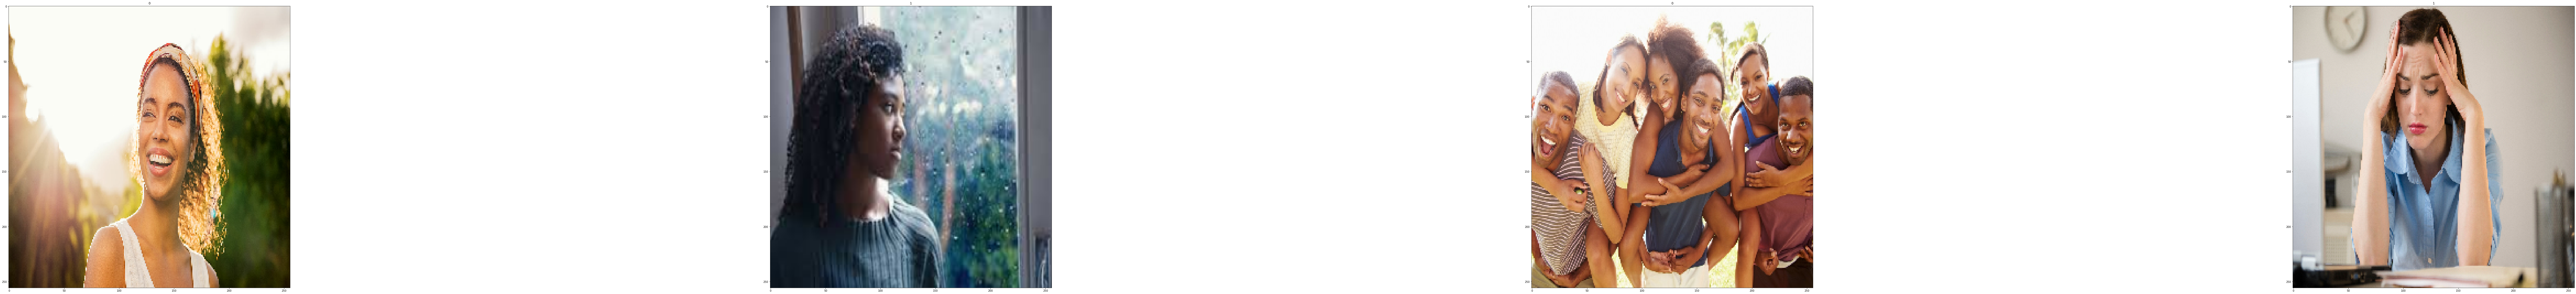

In [20]:
#Visualizing the labels assigned to the data
fig, ax =plt.subplots(ncols=4, figsize=(202,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

In [21]:
batch[1]

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1], dtype=int32)

## Data PreProcessing

scaling the data

In [22]:
data_img = data_img.map(lambda x,y: (x/255, y))

In [25]:
data_img.as_numpy_iterator().next()[0].max()

1.0

## Splitting Data

In [34]:
len(data_img)

9

In [30]:
train_size = int(len(data_img)*.7)
val_size = int(len(data_img)*.2)+1
test_size = int(len(data_img)*.1)+1


In [33]:
val_size

2

In [35]:
train = data_img.take(train_size)
val = data_img.skip(train_size).take(val_size)
test = data_img.skip(train_size+val_size).take(test_size)

In [37]:
len(val)

2

## Building Deep Learning Model

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [40]:
model = Sequential()

In [42]:
#applying convolutional layers
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [43]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

## Model Training

In [46]:
logdir = '/content/logs'

In [47]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [48]:
history = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
6/6 [==============================] - 19s 3s/step - loss: 1.2492 - accuracy: 0.5417 - val_loss: 0.8401 - val_accuracy: 0.4844
Epoch 2/20
6/6 [==============================] - 17s 3s/step - loss: 0.7104 - accuracy: 0.5260 - val_loss: 0.6714 - val_accuracy: 0.7188
Epoch 3/20
6/6 [==============================] - 17s 3s/step - loss: 0.6575 - accuracy: 0.7188 - val_loss: 0.5728 - val_accuracy: 0.7969
Epoch 4/20
6/6 [==============================] - 17s 3s/step - loss: 0.5709 - accuracy: 0.7969 - val_loss: 0.5358 - val_accuracy: 0.7812
Epoch 5/20
6/6 [==============================] - 19s 3s/step - loss: 0.4449 - accuracy: 0.8073 - val_loss: 0.4540 - val_accuracy: 0.7656
Epoch 6/20
6/6 [==============================] - 17s 3s/step - loss: 0.4585 - accuracy: 0.7865 - val_loss: 0.3283 - val_accuracy: 0.8750
Epoch 7/20
6/6 [==============================] - 15s 2s/step - loss: 0.3511 - accuracy: 0.8802 - val_loss: 0.3281 - val_accuracy: 0.9219
Epoch 8/20
6/6 [==================

## Plotting Performance

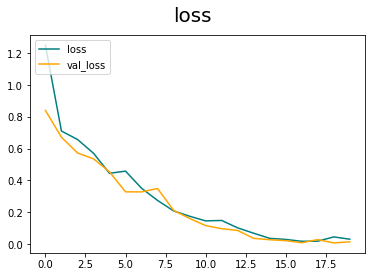

In [49]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

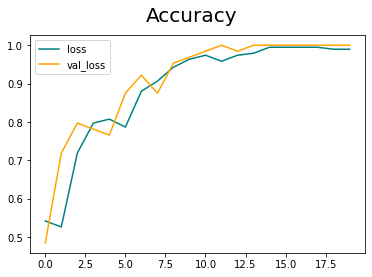

In [51]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='loss')
plt.plot(history.history['val_accuracy'], color='orange', label='val_loss')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

Performance Evaluation

In [52]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [53]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [54]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

In [55]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


Model Testing

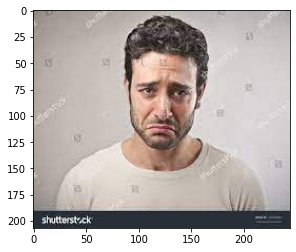

In [68]:
img = cv2.imread('/content/test.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

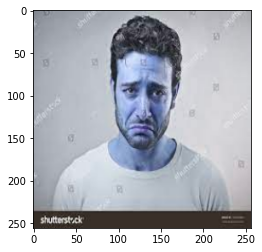

In [69]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [70]:
np.expand_dims(resize, 0).shape


(1, 256, 256, 3)

In [71]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [72]:
yhat

array([[0.9988779]], dtype=float32)

model has successfuly predicted the label which is sad [1]

## Saving Model

In [73]:
from tensorflow.keras.models import load_model

In [74]:
model.save('MkHappySadModel.h5')

In [75]:
new_model = load_model('/content/MkHappySadModel.h5')



```
By MutegiMk and Credit to Renote
```

